In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from cycler import cycler
import pprint
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.optim as optim

from models import *
from optim import get_lr_scheduler
from optim import lr_scheduler_list

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.11.0
cuda is available.


In [4]:
colors = ['limegreen', 'mediumpurple', 'darkorange', 
          'dodgerblue', 'lightcoral', 'goldenrod', 
          'indigo', 'darkgreen', 'navy', 'brown']

cc = (cycler(linestyle=['-', '--', '-.']) * cycler(color=colors))

print(cc)

(cycler('linestyle', ['-', '--', '-.']) * cycler('color', ['limegreen', 'mediumpurple', 'darkorange', 'dodgerblue', 'lightcoral', 'goldenrod', 'indigo', 'darkgreen', 'navy', 'brown']))


In [6]:
cfg_model = {}
cfg_model['in_channels'] = 20  # 19-21
cfg_model['out_dims'] = 3  # 2 or 3
cfg_model['seq_length'] = 2000
cfg_model['model'] = '1D-ResNeXt-5x'
cfg_model['generator'] = ResNet1D
cfg_model['block'] = BottleneckBlock1D
cfg_model['conv_layers'] = [3, 4, 6, 3]
cfg_model['fc_stages'] = 3
cfg_model['use_age'] = 'fc'
cfg_model['final_pool'] = 'max'
cfg_model['base_channels'] = 64
cfg_model['groups'] = 32
cfg_model['LR'] = None
cfg_model['activation'] = 'relu'
model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)

In [7]:
base_lr = 1
iterations = (250000 * 32) // 128
warmup_steps = 10000 # iterations // 10

In [8]:
optimizer = optim.AdamW(model.parameters(),
                        lr=base_lr,
                        weight_decay=1e-3)

In [9]:
pprint.pprint(lr_scheduler_list)

['constant_with_decay',
 'transformer_style',
 'cosine_decay_with_warmup_half',
 'cosine_decay_with_warmup_one_and_half',
 'cosine_decay_with_warmup_two_and_half',
 'linear_with_warmup']


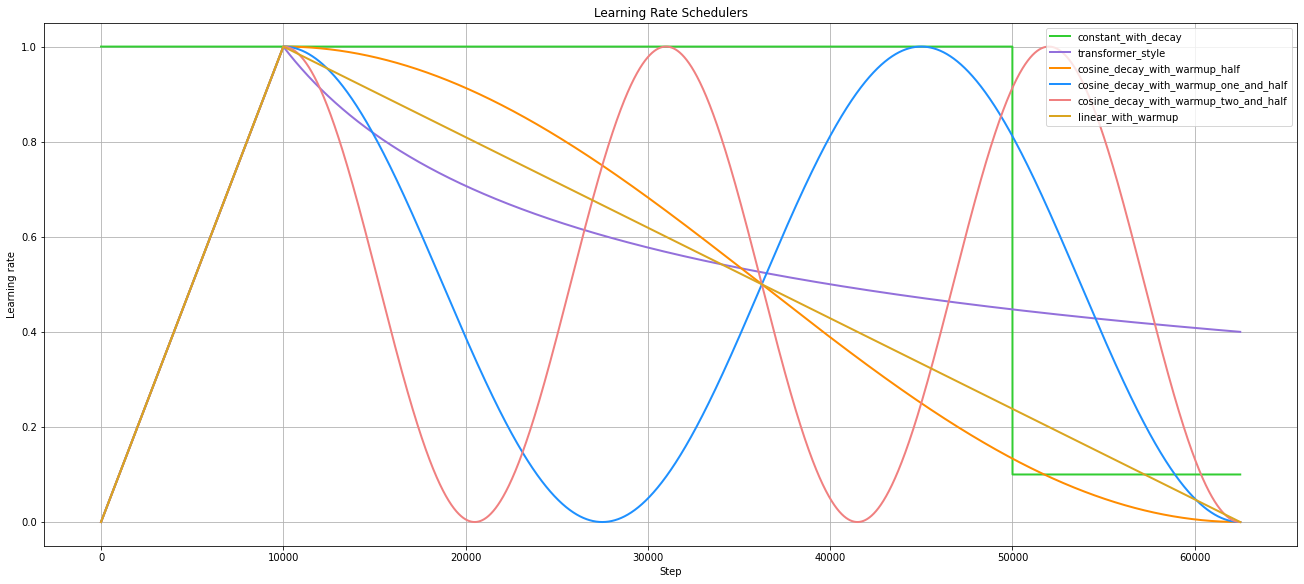

In [10]:
fig = plt.figure(num=1, clear=True, 
                 constrained_layout=True, figsize=(18.0, 8.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Learning Rate Schedulers')
ax.set_prop_cycle(cc)
ax.set_xlabel('Step')
ax.set_ylabel('Learning rate')

for s, scheduler_type in enumerate(lr_scheduler_list):
    scheduler = get_lr_scheduler(optimizer, scheduler_type=scheduler_type, 
                                 iterations=iterations, warmup_steps=warmup_steps)

    lr_record = []
    
    for i in range(iterations):
        optimizer.step()
        scheduler.step()
        lr_record.append(optimizer.state_dict()['param_groups'][0]['lr'])
    
    ax.plot(np.arange(len(lr_record)), lr_record, lw=2, label=scheduler_type)
    
ax.legend()
ax.grid(True)
plt.show()
fig.clear()
plt.close(fig)